# SMDP_IOQL

In [1]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
from tqdm import tqdm
import random
import gym
from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
'''
The environment used here is extremely similar to the openai gym ones.
At first glance it might look slightly different. 
The usual commands we use for our experiments are added to this cell to aid you
work using this environment.
'''

#Setting up the environment
import gym
env = gym.make('Taxi-v3')

#env.seed(0)

state_shape = env.observation_space
no_of_actions = env.action_space.n

print("State shape:", state_shape)
print("Number of Actions: ",no_of_actions)
print("Sampled Action",env.action_space.sample())
print("----"*20)

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''
Passenger_locations = {0:"R(ed)",1:"G(reen)",2:"Y(ellow)",3:"B(lue)",4:"in taxi"}
Destinations = {0:"R(ed)",1:"G(reen)",2:"Y(ellow)",3:"B(lue)"}
Actions = {0: "move south", 1: "move north", 2: "move east", 3: "move west", 4: "pickup passenger",5: "drop off passenger"}
print("Actions: ",Actions)
print("Passenger_locations: ",Passenger_locations)
print("Destinations: ",Destinations)
print("----"*20)
state = env.reset()
''' This returns the initial state (when environment is reset) '''

print("Current_State: ",state)
print("Decoded Current_State [taxi_row, taxi_col, passenger_location, destination]: ",list(env.decode(state)))
print(env.render())
print("----"*20)

action = env.action_space.sample()
''' We take a random action now '''

print("Sampled Action: ", action)
print("----"*20)

next_state, reward, done, info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print("Next_State: ",next_state)
print("Decoded Next_State [taxi_row, taxi_col, passenger_location, destination]: ",list(env.decode(next_state)))
print("Reward: ",reward)
print("Done: ", done)
print("Info: ", info)
print("----"*20)

print(env.render())
print("----"*20)

State shape: Discrete(500)
Number of Actions:  6
Sampled Action 2
--------------------------------------------------------------------------------
Actions:  {0: 'move south', 1: 'move north', 2: 'move east', 3: 'move west', 4: 'pickup passenger', 5: 'drop off passenger'}
Passenger_locations:  {0: 'R(ed)', 1: 'G(reen)', 2: 'Y(ellow)', 3: 'B(lue)', 4: 'in taxi'}
Destinations:  {0: 'R(ed)', 1: 'G(reen)', 2: 'Y(ellow)', 3: 'B(lue)'}
--------------------------------------------------------------------------------
Current_State:  42
Decoded Current_State [taxi_row, taxi_col, passenger_location, destination]:  [0, 2, 0, 2]
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

None
--------------------------------------------------------------------------------
Sampled Action:  4
--------------------------------------------------------------------------------
Next_State:  42
Decoded Next_State [taxi_row, taxi_col, passenger_location, destination]:  [0, 2, 0, 2]
R

In [3]:
env.nS,env.nA

(500, 6)

State = ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination

## Actions and Options
##### Actions: There are 6 discrete deterministic actions: 0: move south; 1: move north; 2: move east; 3: move west; 4: pick passenger up; and 5: drop passenger off.
##### Options: Options to move the taxi to each of the four designated locations, executable when the taxi is not already there. i.e [move_to_R,move_to_G,move_to_Y,move_to_B]


In [4]:
    
'''
Now the new action space will contain
Primitive Actions: ["up", "right", "down", "left", "pickup", "drop off"]
Options: ["move_to_R","move_to_G","move_to_Y","move_to_B"]
Total Actions :["up", "right", "down", "left", "pickup", "drop off", "move_to_R","move_to_G","move_to_Y","move_to_B"]
Corresponding to [0,1,2,3,4,5,6,7,8,9]
'''
policy_r = np.array([[0, 3, 0, 0, 0], [1, 3, 0, 0, 0], [1, 3, 3, 3, 3], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]])
policy_g = np.array([[0, 0, 2, 2, 0], [0, 0, 1, 1, 1], [2, 2, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]])
policy_y = np.array([[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 3, 3, 3, 3], [0, 1, 1, 1, 1], [0, 1, 1, 1, 1]])
policy_b = np.array([[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [2, 2, 2, 0, 0], [1, 1, 1, 0, 0], [1, 1, 1, 0, 3]])

Options_Policy = np.array([policy_r, policy_g, policy_y, policy_b])

In [5]:
def plot_policy(policy,message = "Policy plot"):
        DOWN = 0
        UP = 1
        LEFT = 3
        RIGHT = 2

        plt.title(message,fontsize=18)
        plt.pcolor(policy, edgecolors='k', linewidths=2) #,cmap="rainbow"
        plt.colorbar()
        def x_direct(a):
            if a in [UP, DOWN]:
                return 0
            return 1 if a == RIGHT else -1
        def y_direct(a):
            if a in [RIGHT, LEFT]:
                return 0
            return 1 if a == UP else -1
        policyx = np.vectorize(x_direct)(policy)
        policyy = np.vectorize(y_direct)(policy)
        idx = np.indices(policy.shape)
        plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        ax = plt.gca()
        ax.invert_yaxis()

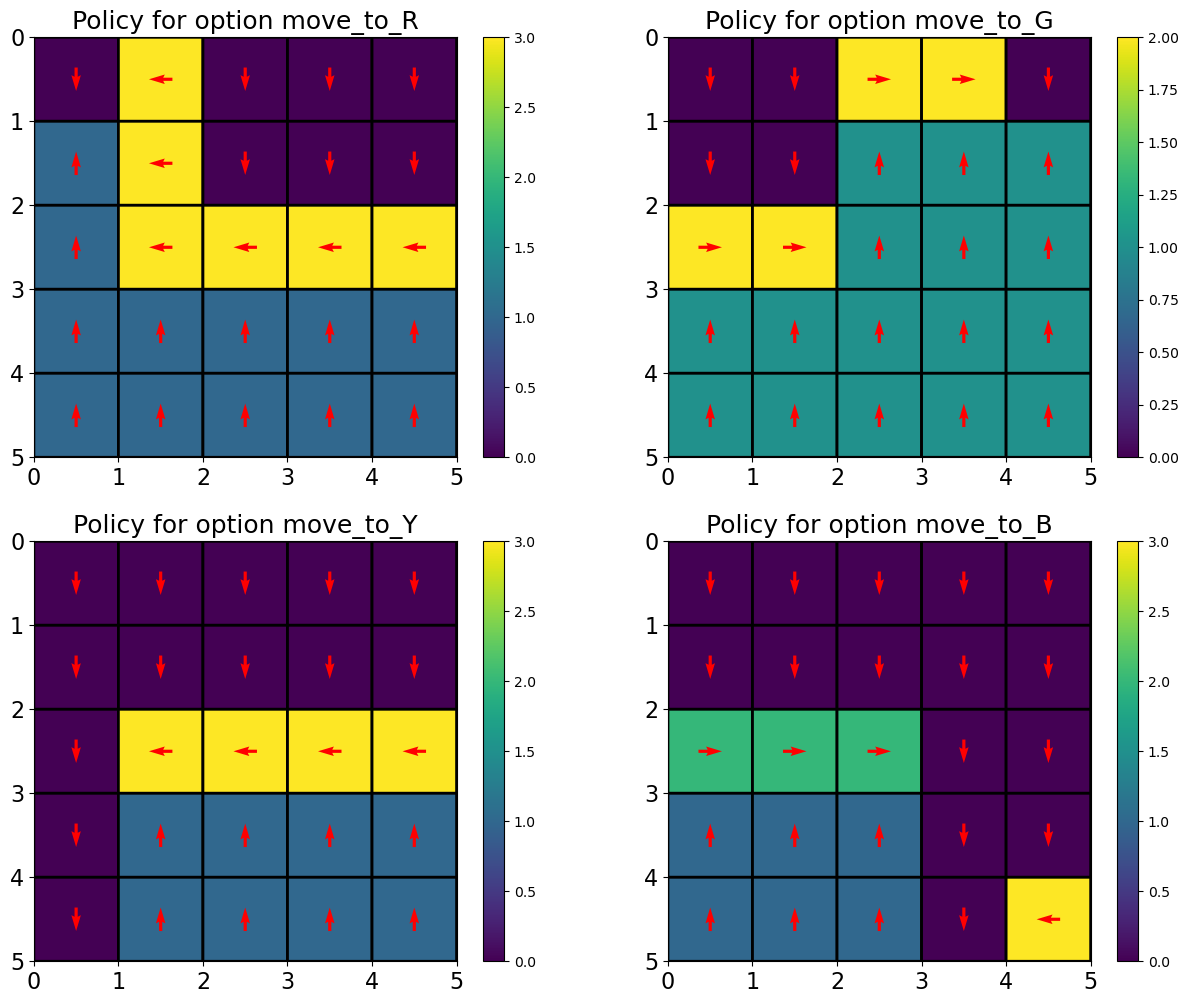

In [6]:
Options_list = ["move_to_R","move_to_G","move_to_Y","move_to_B"]
plt.figure(figsize=[15,12])
for i in range(1,5):
    plt.subplot(2,2,i)
    plot_policy(Options_Policy[i-1],message="Policy for option {}".format(Options_list[i-1]))

# SMDP Q Learning

In [7]:
class SMDP_Q_Learning:
    def __init__(self,env,num_options=4,Options_Policy=Options_Policy,epsilon_start=1,epsilon_decay=0.9,epsilon_end=0.001,gamma=0.9,alpha0=0.4):
        self.env = env
        #Options #
        self.Q_Options = Options_Policy#np.array([np.zeros([25,env.nA-2]) for _ in range(4)]) # [move_to_R,move_to_G,move_to_Y,move_to_B]
        self.Destination_Coord = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]} # {0: 'R(ed)', 1: 'G(reen)', 2: 'Y(ellow)', 3: 'B(lue)'}
        self.epsilon = epsilon_start
        self.epsilon_decay = epsilon_decay
        self.epsilon_end = epsilon_end
        self.gamma = gamma 
        self.alpha0 = alpha0
        self.q_values_SMDP = np.zeros([env.nS,env.nA+num_options])
        self.update_frequency_SMDP = np.zeros([env.nS,env.nA+num_options])
        self.options_epsilon = [epsilon_start]*num_options
    def egreedy_policy(self,q_values,state,epsilon):
        if np.random.rand()<self.epsilon:
                return np.random.choice(np.arange(len(q_values[state]))) 
        else:
            return np.argmax(q_values[state])
    def Options(self,option_num,state):
        #optact = self.egreedy_policy(self.Q_Options[option_num],state,self.options_epsilon[option_num])
        #self.options_epsilon[option_num] = max(self.options_epsilon[option_num]*self.epsilon_decay,self.epsilon_end)
        optact = self.Q_Options[option_num][state//5,state%5]
        return optact        
        
    def learn(self,num_epochs):
        Total_Rewards = []
        for epoch in tqdm(range(num_epochs)):
            #print(epoch)
            state = self.env.reset()    
            done = False
            episode_reward = 0
            
            # While episode is not over
            while not done:
                # Choose action        
                action = self.egreedy_policy(self.q_values_SMDP, state, epsilon=self.epsilon)
                self.epsilon = max(self.epsilon_end,self.epsilon*self.epsilon_decay)

                # Checking if primitive action
                if action < self.env.nA:
                    # Perform regular Q-Learning update for state-action pair
                    state_next, reward, done, _ = env.step(action)
                    self.q_values_SMDP[state,action]+=self.alpha0*(reward+self.gamma*max(self.q_values_SMDP[state_next,:])-self.q_values_SMDP[state,action])
                    self.update_frequency_SMDP[state,action]+=1 
                    state = state_next
                    episode_reward+=reward


                # Checking if action chosen is an option
                reward_bar = 0
                if action >= self.env.nA: # action 
                    option_num = action-self.env.nA
                    start_state = np.copy(state)
                    start_state_decoded = list(env.decode(start_state))
                    state_in_option = start_state_decoded[0]*5+start_state_decoded[1]
                    optdone = False
                    step = 0
                    while (optdone == False):
                        #print(step)
                        #print(option_num,state_in_option)
                        optact = self.Options(option_num,state_in_option) 
                        next_state, reward, done,_ = env.step(optact)
                        next_state_decoded = list(env.decode(next_state))
                        next_state_in_option =next_state_decoded[0]*5+next_state_decoded[1]
                        next_state_coord = [next_state_decoded[0],next_state_decoded[1]]
                        
                        if(next_state_coord==self.Destination_Coord[option_num] or step==1000):
                            optdone = True

                        # Is this formulation right? What is this term?
                        # The Formulaion is not correct because later states should be discounted more
                        episode_reward+=reward
                        reward_bar = reward_bar + (self.gamma**step)*reward
                        #self.Q_Options[option_num][state_in_option,optact]+=self.alpha0*(reward+(self.gamma**step)*max(self.Q_Options[option_num][next_state_in_option,:])-self.Q_Options[option_num][state_in_option,optact])
                        

                        # Complete SMDP Q-Learning Update
                        # Remember SMDP Updates. When & What do you update? 

                        state_in_option = next_state_in_option
                        step+=1
                    state = (state_in_option*5 + start_state_decoded[2]) * 4 + start_state_decoded[3]

                    self.q_values_SMDP[start_state,action]+=self.alpha0*(reward_bar+(self.gamma**step)*max(self.q_values_SMDP[state,:])-self.q_values_SMDP[start_state,action])
                    self.update_frequency_SMDP[start_state,action]+=1 
            Total_Rewards.append(episode_reward)
        return Total_Rewards,self.q_values_SMDP,self.update_frequency_SMDP,self.Q_Options


In [8]:
smdp = SMDP_Q_Learning(env)
Total_Rewards,Q_Values_SMDP,Update_Frequency_SMDP,Q_Options_SMDP = smdp.learn(num_epochs=10000)

100%|██████████| 10000/10000 [00:02<00:00, 4115.97it/s]


Text(0.5, 1.0, 'Reward Curve')

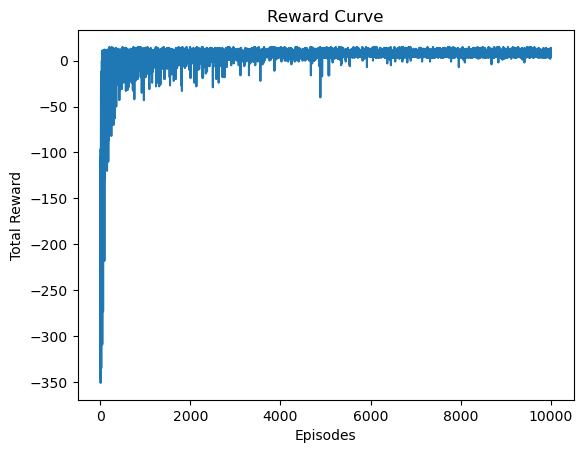

In [9]:
plt.plot(np.arange(len(Total_Rewards)),Total_Rewards)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Reward Curve")

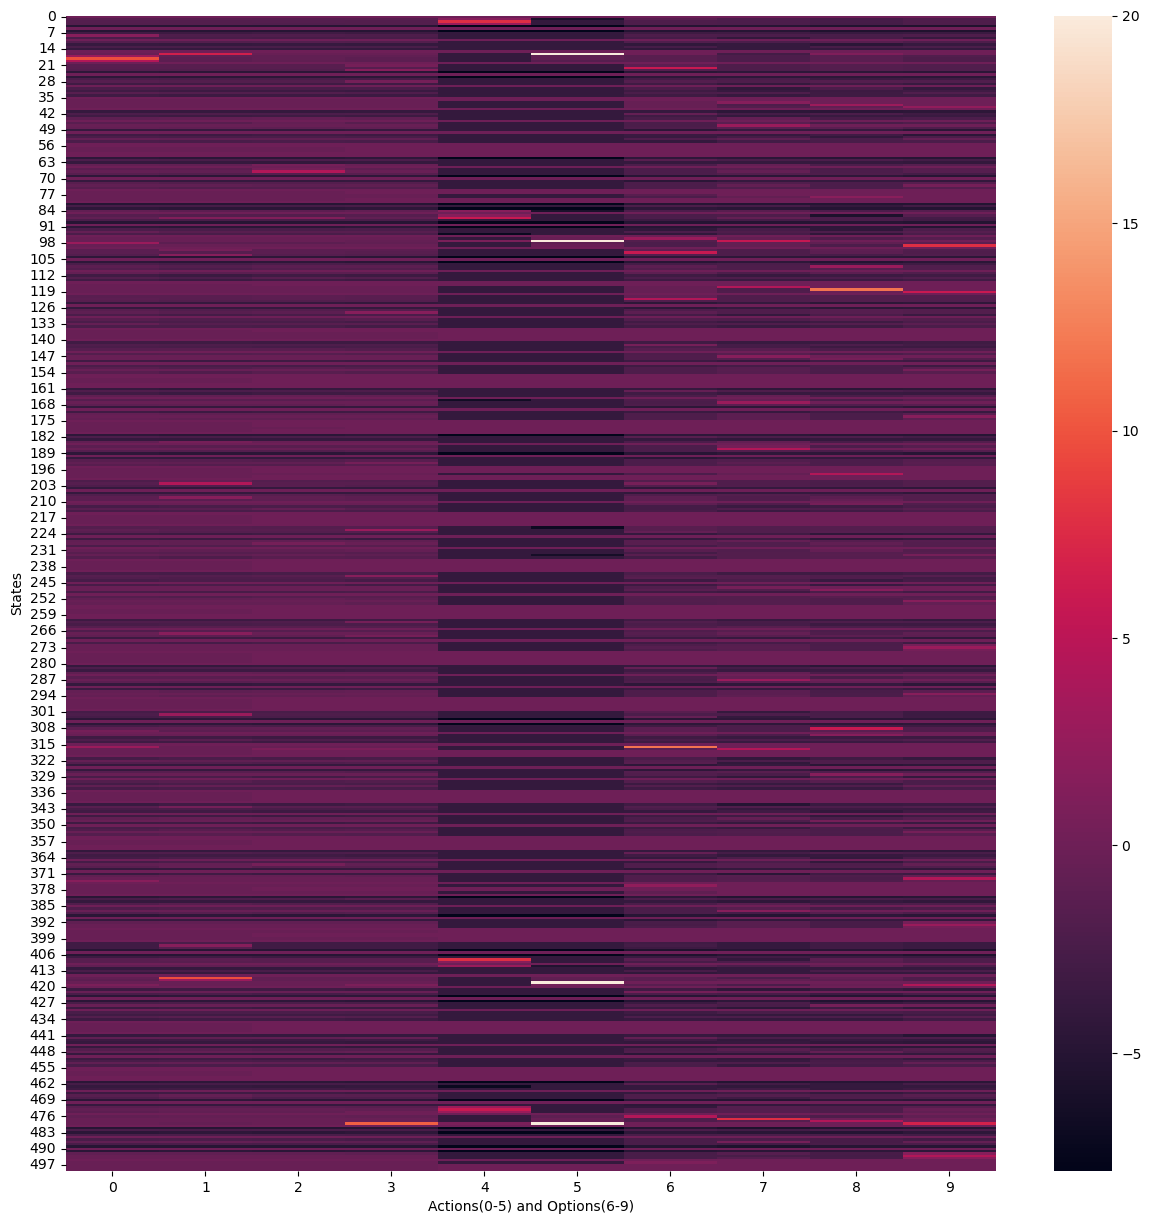

In [10]:
import seaborn as sns
plt.figure(figsize = (15,15))
sns.heatmap(Q_Values_SMDP)
plt.xlabel("Actions(0-5) and Options(6-9)")
plt.ylabel("States")
plt.show()

Text(0.5, 1.0, 'Update Frequency')

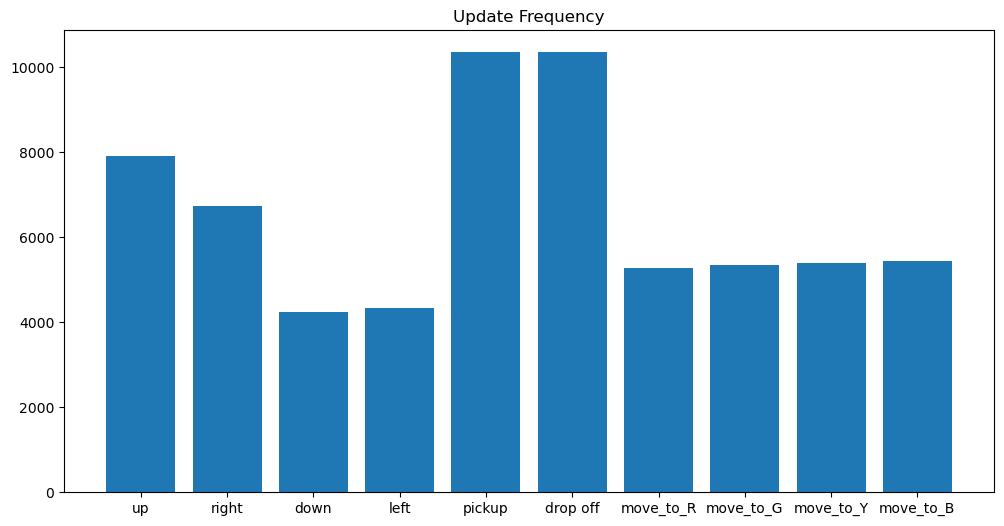

In [11]:
plt.figure(figsize=[12,6])
Total_Actions = ["up", "right", "down", "left", "pickup", "drop off", "move_to_R","move_to_G","move_to_Y","move_to_B"]
plt.bar(Total_Actions,Update_Frequency_SMDP.sum(axis=0))
plt.title("Update Frequency")

# Intra Option Q Learning

In [12]:
class Intra_Option_Q_Learning:
    def __init__(self,env,num_options=4,Q_Options=Options_Policy,epsilon_start=0.5,epsilon_decay=0.95,epsilon_end=0.001,gamma=0.9,alpha0=0.4):
        self.env = env
        self.Q_Options = Q_Options #np.array([np.zeros([25,env.nA-2]) for _ in range(4)]) # [move_to_R,move_to_G,move_to_Y,move_to_B]
        self.Destination_Coord = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]} # {0: 'R(ed)', 1: 'G(reen)', 2: 'Y(ellow)', 3: 'B(lue)'}
        self.epsilon = epsilon_start
        self.epsilon_decay = epsilon_decay
        self.epsilon_end = epsilon_end
        self.gamma = gamma 
        self.alpha0 = alpha0
        self.q_values_SMDP_Intra = np.zeros([env.nS,env.nA+num_options])
        self.update_frequency_SMDP_Intra = np.zeros([env.nS,env.nA+num_options])
        self.options_epsilon = [epsilon_start]*num_options
    def egreedy_policy(self,q_values,state,epsilon):
        if np.random.rand()<self.epsilon:
                return np.random.choice(np.arange(len(q_values[state]))) 
        else:
            return np.argmax(q_values[state])
    def Options(self,option_num,state):
        #optact = self.egreedy_policy(self.Q_Options[option_num],state,self.options_epsilon[option_num])
        #self.options_epsilon[option_num] = max(self.options_epsilon[option_num]*self.epsilon_decay,self.epsilon_end)
        optact = self.Q_Options[option_num][state//5,state%5]
        return optact        
        
    def learn(self,num_epochs):
        Total_Rewards = []
        for epoch in tqdm(range(num_epochs)):
            #print(epoch)
            state = self.env.reset()    
            done = False
            episode_reward = 0
            
            # While episode is not over
            while not done:
                # Choose action        
                action = self.egreedy_policy(self.q_values_SMDP_Intra, state, epsilon=self.epsilon)
                self.epsilon = max(self.epsilon_end,self.epsilon*self.epsilon_decay)

                # Checking if primitive action
                if action < self.env.nA:
                    # Perform regular Q-Learning update for state-action pair
                    state_next, reward, done, _ = env.step(action)
                    self.q_values_SMDP_Intra[state,action]+=self.alpha0*(reward+self.gamma*max(self.q_values_SMDP_Intra[state_next,:])-self.q_values_SMDP_Intra[state,action])
                    self.update_frequency_SMDP_Intra[state,action]+=1 
                    state = state_next
                    episode_reward+=reward


                # Checking if action chosen is an option
                reward_bar = 0
                if action >= self.env.nA: # action 
                    option_num = action-self.env.nA
                    start_state = np.copy(state)
                    start_state_decoded = list(env.decode(start_state))
                    state_in_option = start_state_decoded[0]*5+start_state_decoded[1]
                    optdone = False
                    step = 0
                    while (optdone == False):
                        #print(step)
                        #print(option_num,state_in_option)
                        optact = self.Options(option_num,state_in_option) 
                        next_state, reward, done,_ = env.step(optact)
                        next_state_decoded = list(env.decode(next_state))
                        next_state_in_option =next_state_decoded[0]*5+next_state_decoded[1]
                        next_state_coord = [next_state_decoded[0],next_state_decoded[1]]
                        
                        if(next_state_coord==self.Destination_Coord[option_num]):
                            optdone = True

                        # Is this formulation right? What is this term?
                        # The Formulaion is not correct because later states should be discounted more
                        episode_reward+=reward
                        reward_bar = reward_bar + (self.gamma**step)*reward
                        #self.Q_Options[option_num][next_state_in_option,optact]+=self.alpha0*(reward+(self.gamma**step)*max(self.Q_Options[option_num][next_state_in_option,:])-self.Q_Options[option_num][next_state_in_option,optact])
                        self.q_values_SMDP_Intra[start_state,optact]+=self.alpha0*(reward_bar+(self.gamma**step)*max(self.q_values_SMDP_Intra[state,:])-self.q_values_SMDP_Intra[start_state,optact])
                        self.update_frequency_SMDP_Intra[start_state,optact]+=1
                        if(optdone):
                            self.q_values_SMDP_Intra[start_state,action]+=self.alpha0*(reward_bar+(self.gamma**step)*max(self.q_values_SMDP_Intra[state,:])-self.q_values_SMDP_Intra[start_state,action])
                        else:
                            self.q_values_SMDP_Intra[start_state,action]+=self.alpha0*(reward_bar+(self.gamma**step)*self.q_values_SMDP_Intra[state,action]-self.q_values_SMDP_Intra[start_state,action])
                        self.update_frequency_SMDP_Intra[start_state,action]+=1 

                        # Complete SMDP Q-Learning Update
                        # Remember SMDP Updates. When & What do you update? 

                        state_in_option = next_state_in_option
                        step+=1
                    state = (state_in_option*5 + start_state_decoded[2]) * 4 + start_state_decoded[3]

                    self.q_values_SMDP_Intra[start_state,action]+=self.alpha0*(reward_bar+(self.gamma**step)*max(self.q_values_SMDP_Intra[state,:])-self.q_values_SMDP_Intra[start_state,action])
                    self.update_frequency_SMDP_Intra[start_state,action]+=1 
            Total_Rewards.append(episode_reward)
        return Total_Rewards,self.q_values_SMDP_Intra,self.update_frequency_SMDP_Intra,self.Q_Options


In [13]:
ioql = Intra_Option_Q_Learning(env)
Total_Rewards_Intra,Q_Values_SMDP_Intra,Update_Frequency_SMDP_Intra,Q_Options_Intra = ioql.learn(num_epochs=10000)

100%|██████████| 10000/10000 [00:03<00:00, 2955.28it/s]


Text(0.5, 1.0, 'Reward Curve')

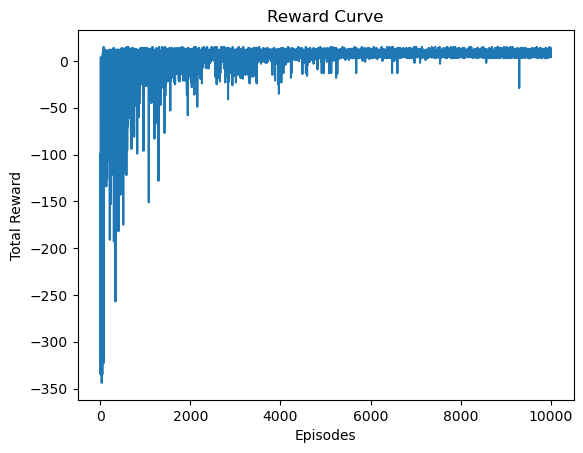

In [14]:
plt.plot(np.arange(len(Total_Rewards_Intra)),Total_Rewards_Intra)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Reward Curve")

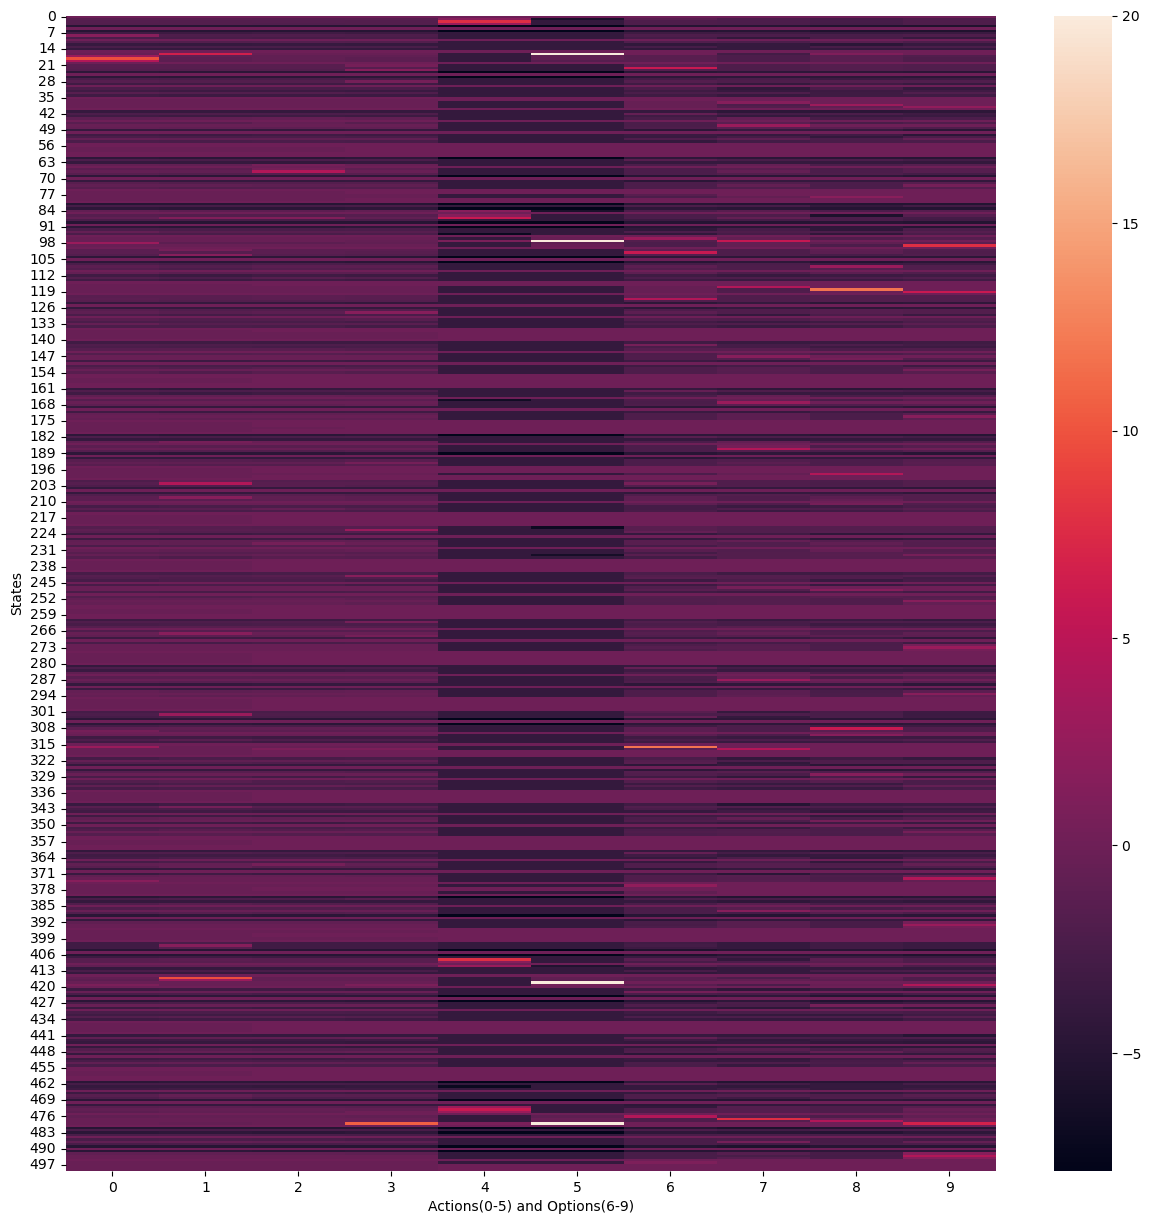

In [15]:
import seaborn as sns
plt.figure(figsize = (15,15))
sns.heatmap(Q_Values_SMDP)
plt.xlabel("Actions(0-5) and Options(6-9)")
plt.ylabel("States")
plt.show()

Text(0.5, 1.0, 'Update Frequency')

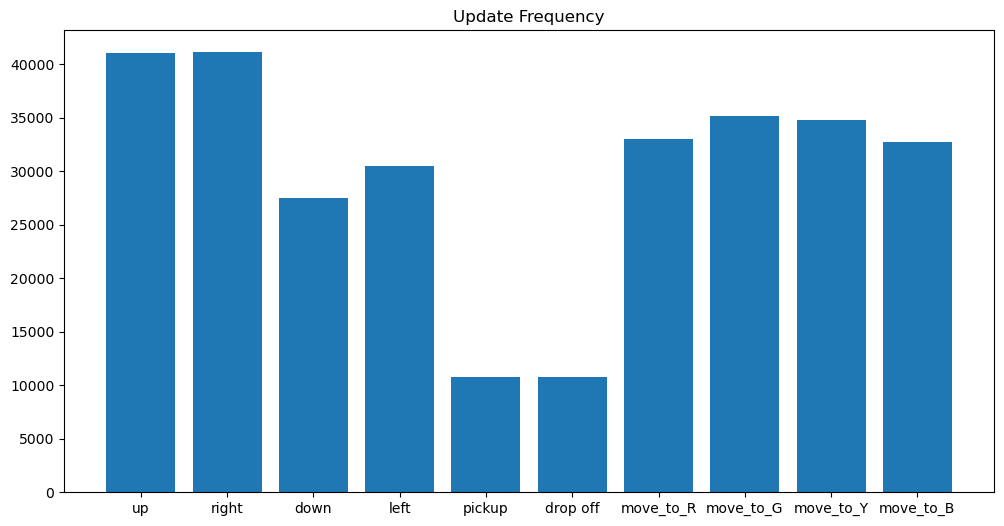

In [16]:
plt.figure(figsize=[12,6])
Total_Actions = ["up", "right", "down", "left", "pickup", "drop off", "move_to_R","move_to_G","move_to_Y","move_to_B"]
plt.bar(Total_Actions,Update_Frequency_SMDP_Intra.sum(axis=0))
plt.title("Update Frequency")